# Libraries and data dir

In [2]:
img_size = 100
img_size_str = str(img_size)
data_dir = "C:/Users/Sean/Desktop/CS3244_Project2/SYKE-plankton_IFCB_2022"
data_path = "F:/data_" + img_size_str + ".csv"
data_undersampled_path = "F:/data_" + img_size_str + "_undersampled.csv"
train_path = "F:/data_" + img_size_str + "_undersampled_train.csv"
test_path = "F:/data_" + img_size_str + "_undersampled_test.csv"

In [1]:
import numpy as np
import os
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
# Remove all file if exists
if os.path.exists(data_path):
    os.remove(data_path)
if os.path.exists(data_undersampled_path):
    os.remove(data_undersampled_path)
if os.path.exists(train_path):
    os.remove(train_path)
if os.path.exists(test_path):
    os.remove(test_path)

# Exploring the dataset

Read dataset and write to csv

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels="inferred",
  seed=42,
  color_mode="grayscale",
  batch_size=None,
  image_size=(img_size,img_size))

with open(data_path, 'a', newline='') as f:
    writer = csv.writer(f)
    for image, labels in ds:
        row = np.append(image.numpy().flatten(),labels.numpy().flatten()[0])
        writer.writerow(row)

Found 63074 files belonging to 50 classes.


Print all class names

In [5]:
class_names = ds.class_names
class_names_dict = {}
for idx, class_name in enumerate(class_names):
    class_names_dict[idx] = class_name
class_names_dict

{0: 'Amylax_triacantha',
 1: 'Aphanizomenon_flosaquae',
 2: 'Aphanothece_paralleliformis',
 3: 'Beads',
 4: 'Centrales_sp',
 5: 'Ceratoneis_closterium',
 6: 'Chaetoceros_sp',
 7: 'Chaetoceros_sp_single',
 8: 'Chlorococcales',
 9: 'Chroococcales',
 10: 'Chroococcus_small',
 11: 'Ciliata',
 12: 'Cryptomonadales',
 13: 'Cryptophyceae-Teleaulax',
 14: 'Cyclotella_choctawhatcheeana',
 15: 'Cymbomonas_tetramitiformis',
 16: 'Dinophyceae',
 17: 'Dinophysis_acuminata',
 18: 'Dolichospermum-Anabaenopsis',
 19: 'Dolichospermum-Anabaenopsis-coiled',
 20: 'Euglenophyceae',
 21: 'Eutreptiella_sp',
 22: 'Gonyaulax_verior',
 23: 'Gymnodiniales',
 24: 'Gymnodinium_like',
 25: 'Heterocapsa_rotundata',
 26: 'Heterocapsa_triquetra',
 27: 'Heterocyte',
 28: 'Katablepharis_remigera',
 29: 'Licmophora_sp',
 30: 'Melosira_arctica',
 31: 'Merismopedia_sp',
 32: 'Mesodinium_rubrum',
 33: 'Monoraphidium_contortum',
 34: 'Nitzschia_paleacea',
 35: 'Nodularia_spumigena',
 36: 'Oocystis_sp',
 37: 'Oscillatoriales'

Show example of image

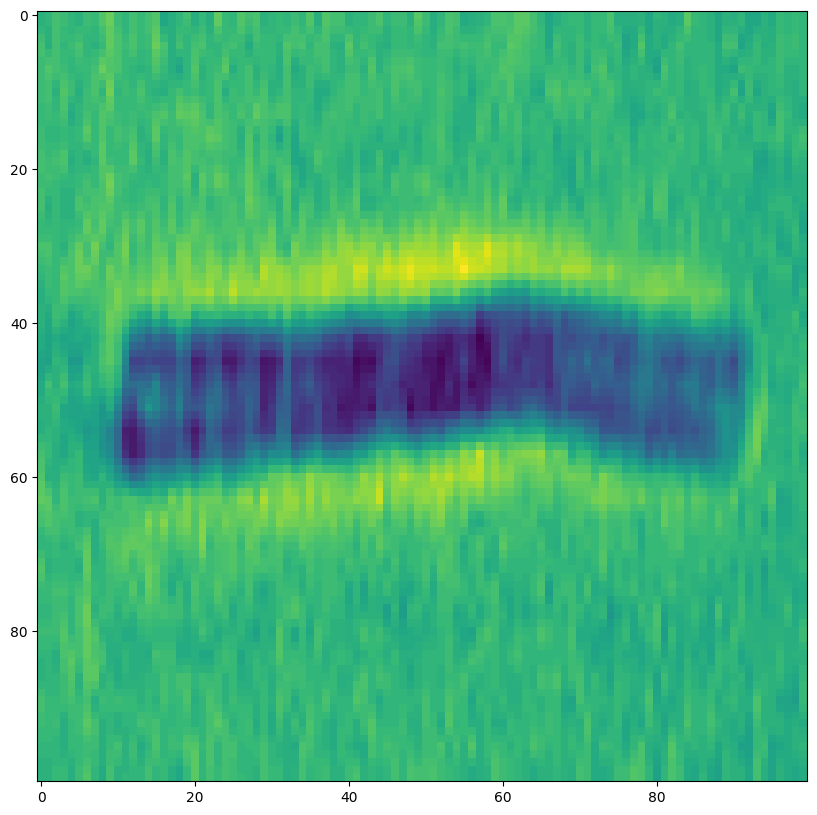

In [6]:
for images, labels in ds.take(1):
    plt.figure(figsize=(10, 10))
    plt.imshow(images.numpy().astype("uint8"))
    break

# Problem: Read csv file directly fails due to high memory usage

In [7]:
# df = pd.read_csv(train_path, header=None)
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

*Dataset Overall Class distribution*

- Cyanophyceae 30428 48.2%
- Cryptophyceae 7543 11.9%
- Euglenophyceae 2349 3.7%
- Dinophyceae 7176 11.3%
- Diatomophyceae 10179 16.1%
- Chrysophyceae 895 1.4%
- Chlorophyta 2687 4.2%
- Ciliates 1375 2.1%
- Others 442 0.7%
    - Katablepharis
    - heterocyte
    - beads
Total: 63074

Idea: Group by classes. Problem: subclasses are not similar.

Idea: undersample Dolichospermum. Problem: Still takes too long.

In [8]:
# count = 0
# with open("F:/data_180.csv") as a:
#     csv_reader = csv.reader(a, delimiter=',')
#     with open("F:/data_180_undersampled.csv", 'a', newline='') as f:
#         writer = csv.writer(f)
#         for row in csv_reader:
#             if (row[-1]) != 18:
#                 writer.writerow(row)
#             elif count >= 6989:
#                 continue
#             else:
#                 count += 1
#                 writer.writerow(row)

Idea: Use chunk. But DT does not have partial_fit

In [9]:

# # Import necessary packages
# from sklearn.linear_model import SGDClassifier
# import pandas as pd
# from tqdm.notebook import tqdm

# chunksize = 20000
# clf = SGDClassifier(alpha=.0001, loss='log', penalty='l2', n_jobs=-1, shuffle=True)
# for train_df in tqdm(pd.read_csv("DATA/creditcard.csv", chunksize=chunksize, iterator=True)):
#     X = train_df
#     Y = train_df['Class']
#     clf.partial_fit(X, Y, classes=[0,1])

# Idea: Exclude Cyanophyceae

In [10]:
cyanophyceae = [18, 19, 1, 37, 47, 10, 35, 9, 31, 2]
with open(data_undersampled_path, 'a', newline='') as f:
    writer = csv.writer(f)
    for image, labels in ds:
        label = labels.numpy().flatten()[0]
        if label not in cyanophyceae:
            row = np.append(image.numpy().flatten(),label)
            writer.writerow(row)

Train test split and save

In [11]:
df = pd.read_csv(data_undersampled_path, header=None)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv(train_path, header=False, index=False)
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv(test_path, header=False, index=False)

In [15]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,183.000000,182.880005,180.899994,179.580002,177.720001,181.000000,180.740005,179.100006,177.679993,179.759995,...,173.299988,176.399994,171.080017,175.239990,172.080002,172.719986,177.499969,177.059998,177.979996,48.0
1,177.000000,177.000000,175.199997,179.300003,177.540009,180.119995,175.820007,178.199997,175.380005,176.720001,...,173.339996,174.599991,175.220016,172.779999,172.899994,177.139999,177.800003,176.000000,176.000000,13.0
2,199.035599,191.460007,190.541000,194.211807,195.466797,190.423004,189.934799,190.923004,193.459396,189.901199,...,179.279999,184.276978,180.895203,184.184418,188.296585,183.898987,187.684998,185.207764,183.512619,16.0
3,196.000000,188.619995,191.199997,194.160004,195.000000,193.300003,191.539993,196.399994,191.119995,194.440002,...,189.000000,189.000000,188.220001,188.660004,189.000000,189.839996,191.600006,192.820007,192.000000,13.0
4,184.960007,183.119995,185.300003,187.720001,186.179993,187.220001,186.960007,184.600006,184.300003,183.279999,...,177.000000,178.399994,177.520004,178.559998,179.820007,181.719986,178.400024,178.000000,184.859970,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22847,197.000000,197.360001,198.399994,197.839996,196.300003,197.959991,196.880005,202.300003,196.119995,201.160004,...,196.860016,195.199997,197.220001,196.979980,195.000000,194.419998,196.799988,198.820007,196.179993,26.0
22848,167.000000,168.880005,169.000000,169.000000,165.720001,165.779999,166.740005,167.699997,168.660004,167.759995,...,160.320007,159.000000,159.259995,160.440002,162.000000,161.580002,159.699982,166.059998,167.000000,21.0
22849,169.000000,169.000000,164.100006,165.479996,168.919998,167.959991,164.000000,163.899994,163.020004,164.720001,...,161.940002,159.299988,161.339996,164.639984,165.459991,162.060013,160.100021,164.820007,164.000000,13.0
22850,176.059998,178.880005,176.800003,175.699997,178.380005,171.220001,172.000000,173.800003,178.339996,179.380005,...,172.339996,172.000000,175.699982,175.440002,169.260010,173.159958,174.000000,174.940002,178.919983,40.0


In [16]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,184.580002,183.679993,183.899994,183.000000,186.740005,183.839996,182.000000,184.199997,184.860001,185.639999,...,181.859985,183.000000,185.100006,178.700012,175.260010,173.980011,173.599991,176.159988,177.860001,16
1,185.000000,186.639999,184.899994,181.100006,179.460007,181.020004,182.119995,179.300003,181.940002,180.279999,...,179.139984,185.300018,181.320007,181.319992,179.299988,176.580002,177.500015,180.459992,178.000000,25
2,189.639999,189.259995,187.399994,189.880005,190.899994,187.520004,186.459992,187.899994,189.720001,191.940002,...,180.420044,186.799927,185.460022,185.000000,185.339996,184.000000,184.699982,181.699951,182.420013,46
3,171.000000,166.300003,168.699997,170.720001,169.360001,167.440002,165.520004,169.199997,169.020004,170.479996,...,166.339996,167.000000,165.960022,163.220001,164.540008,166.580002,163.899994,163.179993,166.000000,12
4,164.000000,163.059998,163.000000,163.860001,166.459992,161.540008,160.740005,163.100006,165.320007,162.899994,...,158.660004,158.599991,160.519989,161.779999,161.000000,160.440002,157.199997,159.000000,159.000000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9789,188.000000,188.000000,188.600006,190.080002,192.960007,191.240005,187.639999,186.199997,187.860001,187.979996,...,186.099976,182.799988,181.360001,182.080002,184.040008,186.920013,184.899994,183.159988,182.000000,45
9790,188.000000,194.580002,193.199997,188.699997,190.459992,183.979996,187.179993,187.600006,190.300003,189.520004,...,185.960022,184.099976,189.779983,190.019989,184.080002,188.720001,186.500000,182.179993,185.000000,13
9791,188.759995,186.440002,190.300003,185.259995,187.000000,187.660004,184.880005,180.399994,184.040008,185.020004,...,181.039993,181.000000,181.440002,182.660004,181.080002,178.839996,179.399994,181.639999,186.700012,4
9792,176.119995,181.940002,180.899994,179.160004,174.539993,177.440002,179.000000,180.500000,182.979996,181.380005,...,173.979981,177.099991,172.820007,170.220001,177.380005,177.280014,175.200012,175.000000,176.959992,21


Overall data distribution

<BarContainer object of 40 artists>

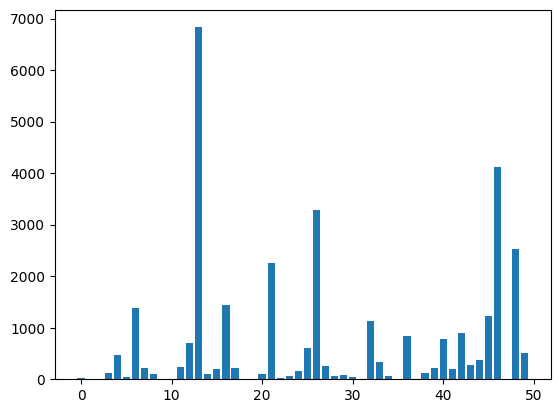

In [18]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

In [14]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

Normalise data

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

PCA

In [17]:
# from sklearn.decomposition import PCA
 
# pca = PCA(n_components=10, random_state=42)
 
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [18]:
# X_train_pca

array([[ -427.23542073,   788.35999244,   578.82645185, ...,
          792.54965761,   -50.67956059,   -26.7489172 ],
       [  -82.1744457 ,   422.46909418,  -153.74990069, ...,
         -192.79222407,  -159.21706362,    95.51550825],
       [  844.10674298, -1002.81388094,  -519.23663313, ...,
           27.59459609,   133.65965328,  -848.71074268],
       ...,
       [  671.90510182,  1122.19138756,  -546.85153295, ...,
          -84.09326695,  -389.04373241,   191.69317746],
       [ -785.18789806,  1054.09442684,   266.29151827, ...,
          -53.97001232,   108.69170582,   143.59762103],
       [  674.03964162,   749.49403495,  -123.02723063, ...,
         -172.68308381,  1041.06889014,  -672.31618484]])

In [19]:
# X_test_pca

array([[ 6.85252840e+02, -4.60682907e+02, -7.04739645e+02, ...,
         4.09839586e+02,  1.01551223e+01, -3.33254430e+02],
       [-2.67907414e+02, -8.08786236e-01,  8.34121990e+01, ...,
        -1.46981570e+01,  2.74045757e+02,  4.42996800e+02],
       [-1.99952814e+03,  6.52255110e+02,  6.65241559e+02, ...,
        -1.16101634e+02,  2.74076874e+02,  1.41619544e+02],
       ...,
       [ 1.44999905e+03, -1.20075106e+02,  1.02961277e+03, ...,
        -2.16320941e+02,  1.37245204e+02,  6.87972832e+02],
       [ 6.58049003e+02, -9.76021574e+01, -6.21105573e+02, ...,
        -2.86619939e+02,  4.54003587e+02, -7.49730774e+02],
       [ 5.12590952e+02,  4.29204648e+02, -8.38780791e+02, ...,
         1.75607225e+02,  6.61915839e+01,  1.47756320e+02]])

In [20]:
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.29363025 0.13387841 0.06038195 0.03738196 0.03316268 0.03195594
 0.02500519 0.01819993 0.0155992  0.01422688]


Attemped to do PCA but 38% info lost

In [ ]:
# X_train

In [ ]:
# X_test

Oversample with SMOTE

Text(0.5, 1.0, 'Before SMOTE')

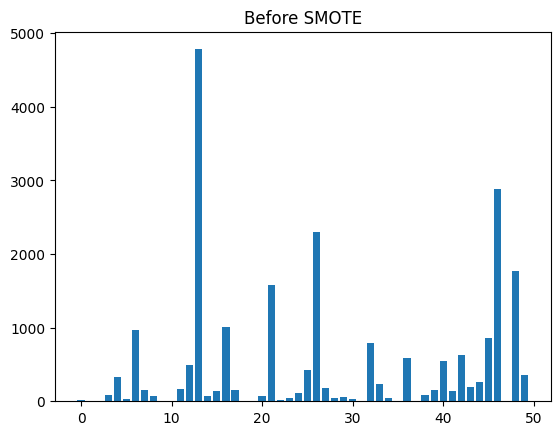

In [21]:
# unique, counts = np.unique(y_train, return_counts=True)
# plt.bar(unique, counts)
# plt.title("Before SMOTE")

In [22]:
# def oversample(X, y):
#     X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
#     unique, counts = np.unique(y_res, return_counts=True)
#     plt.bar(unique, counts)
#     return X_res, y_res

# X_train, y_train = oversample(X_train, y_train)
# unique, counts = np.unique(y_train, return_counts=True)
# plt.bar(unique, counts)
# plt.title("After SMOTE")

MemoryError: Unable to allocate 14.2 GiB for an array with shape (191240, 10000) and data type float64

Diatomophyceae
Dinophyceae

In [ ]:
# diatomophyceae=[46,48,6,7,39,40,4,38,14,29,34,5,30]
# dinophyceae=[25,26,16,17,41,42,43,17,23,24,22,0]

# Decision Tree

In [14]:
max_depth = min(train_df.shape[0], int(sqrt(train_df.shape[1] - 1)))
model = DecisionTreeClassifier(max_depth=max_depth,class_weight="balanced")
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=100)

In [15]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         6
         3.0    0.61290   0.51351   0.55882        37
         4.0    0.34507   0.34028   0.34266       144
         5.0    0.41667   0.38462   0.40000        13
         6.0    0.24471   0.25060   0.24762       415
         7.0    0.23529   0.18750   0.20870        64
         8.0    0.12903   0.14286   0.13559        28
        11.0    0.09859   0.09589   0.09722        73
        12.0    0.16114   0.15888   0.16000       214
        13.0    0.63235   0.65642   0.64416      2049
        14.0    0.16667   0.19355   0.17910        31
        15.0    0.13043   0.15000   0.13953        60
        16.0    0.45898   0.48140   0.46992       430
        17.0    0.27419   0.26154   0.26772        65
        20.0    0.10714   0.09677   0.10169        31
        21.0    0.44091   0.43175   0.43628       674
        22.0    0.00000   0.00000   0.00000         6
        23.0    0.00000   0

# KNN

In [16]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)

KNeighborsClassifier()

In [17]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         6
         3.0    0.39362   1.00000   0.56489        37
         4.0    0.45550   0.60417   0.51940       144
         5.0    0.33333   0.30769   0.32000        13
         6.0    0.66923   0.41928   0.51556       415
         7.0    0.53333   0.25000   0.34043        64
         8.0    0.00000   0.00000   0.00000        28
        11.0    0.41667   0.06849   0.11765        73
        12.0    0.57576   0.35514   0.43931       214
        13.0    0.82303   0.94876   0.88143      2049
        14.0    0.61538   0.25806   0.36364        31
        15.0    0.66667   0.20000   0.30769        60
        16.0    0.62903   0.72558   0.67387       430
        17.0    0.85185   0.35385   0.50000        65
        20.0    0.33333   0.03226   0.05882        31
        21.0    0.77039   0.75668   0.76347       674
        22.0    0.00000   0.00000   0.00000         6
        23.0    1.00000   0

c:\Users\Sean\anaconda3\envs\cs3244_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sean\anaconda3\envs\cs3244_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sean\anaconda3\envs\cs3244_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
